# ДЗ по "Сбор и разметка данных (семинары)"
## Семинар 7. Selenium в Python
Домашнее задание:  
1.	Выберите веб-сайт, который содержит информацию, представляющую интерес для извлечения данных. Это может быть новостной сайт, платформа для электронной коммерции или любой другой сайт, который позволяет осуществлять скрейпинг (убедитесь в соблюдении условий обслуживания сайта).  
2.	Используя Selenium, напишите сценарий для автоматизации процесса перехода на нужную страницу сайта.  
3.	Определите элементы HTML, содержащие информацию, которую вы хотите извлечь (например, заголовки статей, названия продуктов, цены и т.д.).  
4.	Используйте BeautifulSoup для парсинга содержимого HTML и извлечения нужной информации из идентифицированных элементов.  
5.	Обработайте любые ошибки или исключения, которые могут возникнуть в процессе скрейпинга.  
6.	Протестируйте свой скрипт на различных сценариях, чтобы убедиться, что он точно извлекает нужные данные.  
7.	Предоставьте ваш Python-скрипт вместе с кратким отчетом (не более 1 страницы), который включает следующее:   
URL сайта. Укажите URL сайта, который вы выбрали для анализа. Описание. Предоставьте краткое описание информации, которую вы хотели извлечь из сайта. Подход. Объясните подход, который вы использовали для навигации по сайту, определения соответствующих элементов и извлечения нужных данных. Трудности. Опишите все проблемы и препятствия, с которыми вы столкнулись в ходе реализации проекта, и как вы их преодолели. Результаты. Включите образец извлеченных данных в выбранном вами структурированном формате (например, CSV или JSON).  

*Примечание: Обязательно соблюдайте условия обслуживания сайта и избегайте чрезмерного скрейпинга, который может нарушить нормальную работу сайта.*

In [3]:
# Устанавливаем пакеты если они не установлены
# !pip install selenium
# !pip install pandas
# !pip install matplotlib
# !pip install pymongo

  Using cached trio_websocket-0.11.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached outcome-1.3.0.post0-py2.py3-none-any.whl.metadata (2.6 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl.metadata (13 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
    --------------------------------------- 0.1/9.5 MB 2.8 MB/s eta 0:00:04
   - -------------------------------------- 0.5/9.5 MB 4.9 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/9.5 MB 5.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/9.5 MB 7.1 MB/s eta 0:00:02
   ------- -------------------------------- 1.9/9.5 MB 7.9 MB/s eta 0:00:01
   --------- ------------------------------ 2.4/9.5 MB 8.3 MB/s eta 0:00:01
 

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

In [5]:
options = Options()
# Запуск браузера с развернутым экраном
options.add_argument('start-maximized')
# Будем использовать браузер Chrom
driver = webdriver.Chrome(options=options)
# Открываем ссылку
driver.get('https://www.wildberries.ru/')
time.sleep(4)

In [6]:
wait = WebDriverWait(driver, 10)
# Ищем строку поиска
input = wait.until(EC.presence_of_element_located((By.ID, "searchInput")))
# Вводим фразу поиска и нажимаем Enter
input.send_keys('энергетический гель')
input.send_keys(Keys.ENTER)

### Прокручиваем страницу и записываем все ссылки на товары, если есть кнопка "далее" - нажимаем её или выходим из цикла 

In [7]:
# Список ссылок на страницы геля
url_list = []

while True:
    # Количество товаров на странице
    count = None
    while True:
        time.sleep(4)
        # Ожидаем появление объекта (html код) карточек товара
        cards = wait.until(EC.presence_of_all_elements_located((By.XPATH, '//article[@id]')))
        # Выходим из цикла, если при прокрутке страницы, количество товаров не меняется 
        if len(cards) == count:
            break    
        # Вычисляем сколько карточек товара на странице
        count = len(cards)
        # Прокручиваем страницу выполняя JAVA Script
        driver.execute_script('window.scrollBy(0, 1800)')
        time.sleep(2)
        
    # На полностью загруженной странице соберём инфу
    for card in cards:
        # Записываем ссылку каждого товара
        url = card.find_element(By.XPATH, './div/a').get_attribute('href')
        url_list.append(url)
    
    # Проверяем есть ли кнопка дальше
    try:
        next = driver.find_element(By.XPATH,  "//a[@class='pagination-next pagination__next j-next-page']")
        next.click()
    except Exception:
        break

In [8]:
print(f'Всего получено: {len(url_list)} ссылок на товар')

Всего получено: 875 ссылок на товар


### Заходим на каждую страницу найденных товаров и парсим её

In [9]:
driver2 = webdriver.Chrome(options=options)
wait2 = WebDriverWait(driver2, 10)
acb_list = []

# Просматриваем все ссылки на товары
for url_item in url_list:
    acb_dict = {}
    
    driver2.get(url_item)
    # Заносим назание товара
    acb_dict['name'] = wait2.until(EC.presence_of_element_located((By.XPATH, "//h1"))).text
    # Заносим цену товара
    price = wait2.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'price-block__wallet-price')))
    try:
        acb_dict['price'] = float(re.sub(r'[^\d.]+', '', price[1].text))
    except Exception:
        acb_dict['price'] = None
    # Заносим бренд товара
    acb_dict['brend'] = wait2.until(EC.presence_of_element_located((By.CLASS_NAME, "product-page__header-brand"))).text
    # Заносим url ссылку на товар
    acb_dict['url'] = url_item   
    
    # Обрабатываем табличные данные
    table_label = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//th')))
    table_param = wait2.until(EC.presence_of_all_elements_located((By.XPATH, '//td')))
    # Заносим данные в зависимости от названия   
    for i in range(len(table_label)):
        if table_label[i].text == 'Страна производства':
            acb_dict['country'] = table_param[i].text
        elif table_label[i].text == 'Емкость аккумулятора (Ач)':
            try:
                val = table_param[i].text.strip()
                val, *_ = val.split()
                acb_dict['capacity'] = float(re.sub(r'[^\d.]+', '', val))
            except Exception:
                acb_dict['capacity'] = None
        elif table_label[i].text == 'Напряжение':
             try:
                val = table_param[i].text.strip()
                val, *_ = val.split() 
                acb_dict['voltage'] = float(re.sub(r'[^\d.]+', '', val))
             except Exception:
                acb_dict['voltage'] = None
        
    # Добавляем словарь в список товаров
    acb_list.append(acb_dict)

TimeoutException: Message: 


In [11]:
print(f'Обработано {len(acb_list)} страниц')

Обработано 847 страниц


### Посмотрим, что за данные мы получили

In [12]:
df = pd.DataFrame(acb_list)
df.head()

,name,price,brend,url,voltage,country,capacity
0,"Аккумулятор SF 1207, 7Ач, аккумуляторная батар...",832.00,Security Force,https://www.wildberries.ru/catalog/40724205/de...,12.00,Китай,7.00
1,Аккумуляторная батарея AGM 12V 9Ah 1209 для ИБ...,1492.00,Neata Battery,https://www.wildberries.ru/catalog/172398514/d...,12.00,Китай,9.00
2,"Аккумулятор 12v 1.3 Ah F1/T1 для эхолота, весо...",679.00,NPP,https://www.wildberries.ru/catalog/166716189/d...,12.00,Китай,1.30
3,Аккумулятор ибп 12v 40Ah M6/T14 котлов и насос...,4217.00,Thomas,https://www.wildberries.ru/catalog/194125714/d...,12.00,Китай,40.00
4,Аккумулятор ибп 12v 40Ah M6/T14 котлов и насос...,4196.00,Thomas,https://www.wildberries.ru/catalog/168341680/d...,12.00,Китай,40.00


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      847 non-null    object 
 1   price     679 non-null    float64
 2   brend     847 non-null    object 
 3   url       847 non-null    object 
 4   voltage   787 non-null    float64
 5   country   794 non-null    object 
 6   capacity  788 non-null    float64
dtypes: float64(3), object(4)
memory usage: 46.4+ KB


### Какие производители товара представлены на Wildberries

In [14]:
data = df['country'].value_counts()
names = data.index
values = data.values
data

Китай       730
Вьетнам      40
Тайвань       7
Польша        6
Словения      5
Россия        5
中国            1
Name: country, dtype: int64

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


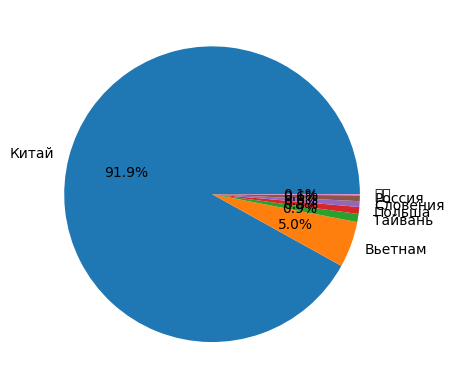

In [15]:
plt.pie(values, autopct='%.1f%%', labels=names)
plt.show()

### Минимальная, максимальная и средняя цена товара в зависимости от его параметра

In [16]:
df.groupby('capacity').agg({'price': ['min', 'mean', 'max']})

price                  
              min     mean      max
capacity                           
0.80       688.00   950.50  1063.00
1.20       492.00   748.22  1189.00
1.30       679.00   721.50   784.00
2.20       683.00   921.75  1239.00
2.30       743.00   853.00  1165.00
2.80       749.00   751.50   754.00
2.90      1120.00  1120.00  1120.00
3.20       900.00  1398.64  1752.00
3.30      1228.00  1347.50  1467.00
4.50       566.00  1189.62  3184.00
5.00       806.00  1359.00  2295.00
5.40      1291.00  1291.00  1291.00
5.50          NaN      NaN      NaN
5.80      2295.00  2295.00  2295.00
6.00       945.00  1523.00  2750.00
7.00       768.00  1276.08  4356.00
7.20       774.00  1660.19  3331.00
7.50      1225.00  1602.40  2395.00
8.00       624.00  1930.50  3237.00
9.00      1164.00  1779.35  3219.00
9.20      1562.00  1638.50  1715.00
10.00         NaN      NaN      NaN
12.00      835.00  2410.48  7917.00
13.00      878.00  1812.00  2746.00
14.00     1868.00  1868.00  1868.00
15.00     2259.00  4243.00  5707.00
17.00     2083.00  4568.70  9487.00
18.00     1923.00  3038.43  5929.00
20.00     2534.00  3599.00  6523.00
22.00      828.00  1638.50  4171.00
23.00      761.00   761.00   761.00
24.00    10164.00 10164.00 10164.00
26.00     2619.00  5056.52  9068.00
28.00     1870.00  3341.43 10627.00
32.00      945.00   945.00   945.00
33.00     4071.00  6492.47 11645.00
35.00      615.00  3864.00  7113.00
38.00         NaN      NaN      NaN
40.00     4196.00  7123.65 12198.00
45.00      808.00  7263.13 17087.00
50.00     8552.00 16030.33 18063.00
55.00      984.00 12145.90 21902.00
57.72     1738.00  1738.00  1738.00
60.00     8248.00  8248.00  8248.00
65.00     7268.00 15269.30 26285.00
70.00    13237.00 13237.00 13237.00
72.00      907.00  1511.27  3523.00
75.00    10234.00 17961.71 29177.00
76.00    33993.00 34294.00 34595.00
80.00     9956.00 10037.50 10120.00
85.00    33563.00 33860.00 34157.00
90.00    26805.00 27042.50 27280.00
100.00   14736.00 19051.67 41474.00
110.00   17508.00 17597.00 17686.00
120.00   16210.00 17150.50 18091.00
150.00   22705.00 22996.25 23590.00
200.00   28743.00 35392.33 43900.00
5000.00   1513.00  1513.00  1513.00
40000.00      NaN      NaN      NaN

### Топ 10 популярных компаний

In [17]:
data = df['brend'].value_counts()
names = data.index
values = data.values
data.head(10)

DELTA BATTERY       174
General Security     61
NPP                  43
Alfa Battery         38
ZUBR                 37
Security Force       35
Sunways              31
CSB                  27
LEOCH                27
Neata Battery        23
Name: brend, dtype: int64

### Запишем полученные данные в БД MongoDB

In [18]:
from pymongo import MongoClient

In [19]:
# Подключение к серверу MongoDB
client = MongoClient('mongodb://localhost:27017/')
# Выбор базы данных и коллекции
db = client['acb']
collection = db['acb_12v']

In [20]:
# Отправим данные в БД MongoDB
collection.insert_many(acb_list)

InsertManyResult([ObjectId('664662bc47dca324292e2589'), ObjectId('664662bc47dca324292e258a'), ObjectId('664662bc47dca324292e258b'), ObjectId('664662bc47dca324292e258c'), ObjectId('664662bc47dca324292e258d'), ObjectId('664662bc47dca324292e258e'), ObjectId('664662bc47dca324292e258f'), ObjectId('664662bc47dca324292e2590'), ObjectId('664662bc47dca324292e2591'), ObjectId('664662bc47dca324292e2592'), ObjectId('664662bc47dca324292e2593'), ObjectId('664662bc47dca324292e2594'), ObjectId('664662bc47dca324292e2595'), ObjectId('664662bc47dca324292e2596'), ObjectId('664662bc47dca324292e2597'), ObjectId('664662bc47dca324292e2598'), ObjectId('664662bc47dca324292e2599'), ObjectId('664662bc47dca324292e259a'), ObjectId('664662bc47dca324292e259b'), ObjectId('664662bc47dca324292e259c'), ObjectId('664662bc47dca324292e259d'), ObjectId('664662bc47dca324292e259e'), ObjectId('664662bc47dca324292e259f'), ObjectId('664662bc47dca324292e25a0'), ObjectId('664662bc47dca324292e25a1'), ObjectId('664662bc47dca324292e25

## Вывод:
Взял информацию с сайта `https://www.wildberries.ru/` об аккумуляторах 12V для ИБП. С помощью скрипта ввёл информацию для поиска, после чего скрипт прокручивал страницу, чтобы загрузились все товары. Далее сохранял все ссылки на аккумуляторы в список и если присутствовала кнопка далее, скрипт нажимал её.
После того как были собраны все ссылки на аккумуляторы, в другом окне браузера открывалась каждая ссылка и извлекались следующие данные:  
- марка;
- напряжение аккумулятора;
- ёмкость аккумулятора;
- бренд;
- страна производитель;
- цена;
- url.
  
Сначала хотел забирать данные с `OnlineTrade.ru` но сайт понял, что я робот и начал задавать различные задания - типа поверните картинку в правильном положении, поэтому перешел на `https://www.wildberries.ru/`. Все параметры (таймауты, число пикселей прокрутки и т.д.) подбирал экспериментальным путём. Отлаживал программу частично в PyCharm Profecional (демо версия), частично в Jupiter Notebook.

Для автоматического сбора данных, нажмите в Jupiter Notebook -> выполнить все (`Run All Cells`)